# Reconhecimento de Captchas

**Aluno:** Pedro de Oliveira Guedes

**Semestre:** 2024.2

## Introdução
Este trabalho tem por objetivo explorar diferentes técnicas para realizar o reconhecimento de caracteres em imagens, mais especificamente em captchas. Para isso, será utilizado um dataset com 10 mil captchas disponibilizado nos arquivos de aula da disciplina de **Introdução à Computação Visual**.

As técnicas empregadas são duas:

1. **HOG + SVM**: ***Histogram of Oriented Gradients***, ou por abreviação ***HOG***, é uma técnica que extrai características de uma imagem baseando-se na orientação dos gradientes. Com as características extraídas, será treinado um modelo de classificação baseado em ***Support Vector Machine***, ou por abreviação ***SVM***, que utilizará as características extraídas e os rótulos das imagens para classificar os caracteres.

2. **CNN**: ***Convolutional Neural Network***, ou por abreviação ***CNN***, é uma técnica de aprendizado profundo que utiliza camadas convolucionais para extrair características de uma imagem. Com as características extraídas, será treinado um modelo de classificação que utilizará as características extraídas e os rótulos das imagens para classificar os caracteres.

Como as imagens necessárias para treino, validação e teste, bem como os rótulos de cada uma delas, já foram fornecidas e já estão separadas, a organização deste trabalho será feita através das seguintes seções:

1. **Funções Comuns**: Nesta seção, serão definidas funções comuns que serão utilizadas em ambas as técnicas, como a avaliação dos modelos gerados.

2. **HOG + SVM**: Nesta seção, será feita a extração das características das imagens utilizando a técnica ***HOG***, bem como o treinamento do modelo de classificação utilizando a técnica ***SVM***. Ao fim, será feita a avaliação do modelo gerado.

3. **CNN**: Nesta seção, será feita a extração das características das imagens utilizando a técnica ***CNN***, bem como o treinamento do modelo de classificação. Ao fim, será feita a avaliação do modelo gerado.

4. **Conclusão**: Nesta seção, será feita uma comparação entre as técnicas utilizadas, bem como uma análise dos resultados obtidos.

## Funções Comuns
Cada uma das funções comuns terá seu próprio subtítulo, com uma breve descrição do objetivo.

### Download e extração do Dataset
A pasta contendo os captchas separados em conjuntos de treino, validação e teste foi disponibilizada no Google Drive. A função abaixo faz o download para a pasta local e extrai o conteúdo do arquivo.

In [1]:
import os
import requests
import zipfile


def save_response_content(response):
    CHUNK_SIZE = 32768

    with open("captcha_10k.zip", "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)


def extract_captchas_zip():
    with zipfile.ZipFile("captcha_10k.zip", 'r') as zip_ref:
        zip_ref.extractall()

    os.remove("captcha_10k.zip")


def extract_query_string(response_content: str) -> dict:
    content_id = response_content.split('<input type="hidden" name="id" value="')[1].split('">')[0]
    export = response_content.split('<input type="hidden" name="export" value="')[1].split('">')[0]
    confirm = response_content.split('<input type="hidden" name="confirm" value="')[1].split('">')[0]
    uuid = response_content.split('<input type="hidden" name="uuid" value="')[1].split('">')[0]

    return {
        'id': content_id,
        'export': export,
        'confirm': confirm,
        'uuid': uuid
    }


def download_captchas_from_google_drive():
    if os.path.exists("captcha_10k"):
        return

    BASE_URL = "https://drive.google.com/uc?export=download"
    DOWNLOAD_BASE_URL = "https://drive.usercontent.google.com/download"

    session = requests.Session()
    response = session.get(BASE_URL, params={'id': "1mZlwRlSOeNBjFYFzI25RgKvomKRHeJ1Y"}, stream=True)
    
    query_string = extract_query_string(response.text)
    
    response = session.get(DOWNLOAD_BASE_URL, params=query_string, stream=True)
    
    save_response_content(response)

    extract_captchas_zip()

### Carregamento do Dataset
A função abaixo passa por todo o dataset de captchas, armazenando as imagens e os rótulos em um dicionário. Os dicionários serão agrupados em três listas separadas, uma para cada conjunto de dados: treino, validação e teste.

In [2]:
import cv2 as opencv


TRAIN = "train"
TEST = "test"
VALIDATION = "validation"

SET_TYPES = [TRAIN, TEST, VALIDATION]


def load_captchas_dataset() -> dict:
    download_captchas_from_google_drive()

    all_captchas = {}
    for filename in os.listdir("captcha_10k/labels"):
        with open(f"captcha_10k/labels/{filename}", 'r') as f:
            all_captchas[filename.split('.')[0]] = {"label": f.read().strip()}
    
    for folder in SET_TYPES:
        for filename in os.listdir(f"captcha_10k/{folder}"):
            file_number = filename.split('.')[0]
            image = opencv.imread(f"captcha_10k/{folder}/{filename}", opencv.IMREAD_GRAYSCALE)
            all_captchas[file_number]["image"] = image / 255.0
            all_captchas[file_number]["type"] = folder

    train_captchas = [all_captchas[filename] for filename in all_captchas if all_captchas[filename]["type"] == TRAIN]
    test_captchas = [all_captchas[filename] for filename in all_captchas if all_captchas[filename]["type"] == TEST]
    validation_captchas = [all_captchas[filename] for filename in all_captchas if all_captchas[filename]["type"] == VALIDATION]

    return {
        TRAIN: train_captchas,
        TEST: test_captchas,
        VALIDATION: validation_captchas
    }

### Exibição dos Captchas
Para entender melhor as imagens, a função abaixo fará a exibição de três delas em conjunto com seus respectivos rótulos.

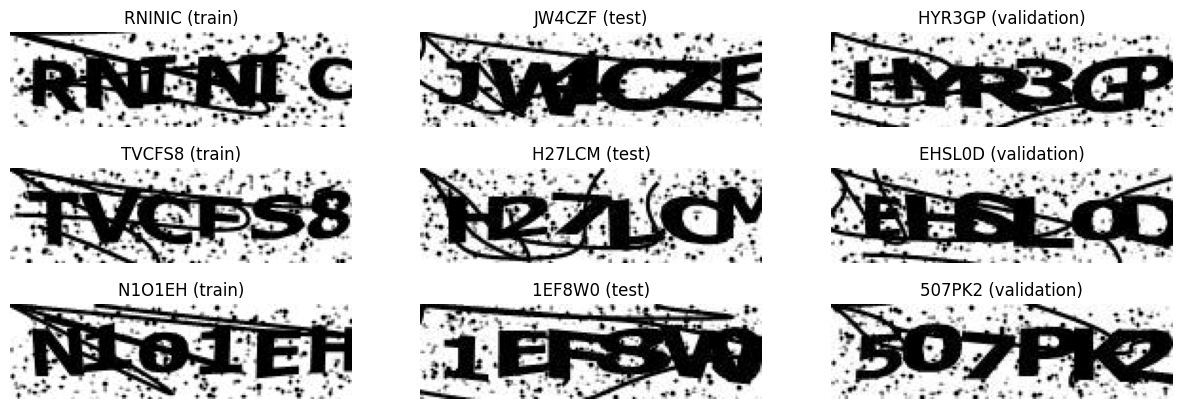

In [3]:
import matplotlib.pyplot as plt


def plot_captchas(captchas: dict, amount_per_type: int = 3):
    _, axs = plt.subplots(amount_per_type, len(SET_TYPES), figsize=(15, 5), squeeze=False)

    for set_type in SET_TYPES:
        for i, captcha in enumerate(captchas[set_type]):
            if i >= amount_per_type:
                break
            axs[i, SET_TYPES.index(set_type)].imshow(captcha["image"], cmap="gray")
            axs[i, SET_TYPES.index(set_type)].set_title(f"{captcha['label']} ({set_type})")
            axs[i, SET_TYPES.index(set_type)].axis("off")

    plt.show()


captchas = load_captchas_dataset()
plot_captchas(captchas)

### Estatísticas dos Captchas
Para melhor entendimento das tratativas necessárias no conjunto de dados, também serão coletadas estatísticas sobre o tamanho das imagens, quantidade de caracteres em cada imagem e quantidade de caracteres total disponível para construção dos captchas.

In [4]:
import pandas as pd


def analyze_captchas_dataset(captchas: dict) -> pd.DataFrame:
    dataset = {
        set_type: { "total": len(captchas[set_type]) } for set_type in SET_TYPES
    }

    for set_type in SET_TYPES:
        distinct_characters = set()
        for captcha in captchas[set_type]:
            for character in captcha["label"]:
                distinct_characters.add(character)

        dataset[set_type]["min_label_length"] = min(len(captcha["label"]) for captcha in captchas[set_type])
        dataset[set_type]["max_label_length"] = max(len(captcha["label"]) for captcha in captchas[set_type])
        dataset[set_type]["distinct_characters"] = len(distinct_characters)
        dataset[set_type]["min_width"] = min(captcha["image"].shape[1] for captcha in captchas[set_type])
        dataset[set_type]["min_height"] = min(captcha["image"].shape[0] for captcha in captchas[set_type])
        dataset[set_type]["max_width"] = max(captcha["image"].shape[1] for captcha in captchas[set_type])
        dataset[set_type]["max_height"] = max(captcha["image"].shape[0] for captcha in captchas[set_type])

    return pd.DataFrame(dataset).T


dataset_analysis = analyze_captchas_dataset(captchas)
dataset_analysis

,total,min_label_length,max_label_length,distinct_characters,min_width,min_height,max_width,max_height
train,8000,6,7,37,180,50,180,50
test,1000,6,7,36,180,50,180,50
validation,1000,6,7,36,180,50,180,50


É possível verificar que todas as imagens possuem as mesmas dimensões de 50x180 pixels, dispensando a necessidade de redimensionamento.

Note que no conjunto de treino existem 37 caracteres distintos, enquanto nos conjuntos de validação e teste existem 36, o que pode levar a predições não reconhecidas.

Além disso, perceba também a diferença entre o tamanho máximo e mínimo de caracteres nos rótulos. Esse problema em específico precisa ser tratado, já que o modelo de classificação espera que todas as imagens tenham o mesmo tamanho de rótulo.

In [5]:
def remove_captchas_with_over_6_characters(captchas: dict) -> dict:
    return {
        set_type: [captcha for captcha in captchas[set_type] if len(captcha["label"]) == 6] for set_type in SET_TYPES
    }

captchas = remove_captchas_with_over_6_characters(captchas)

dataset_analysis = analyze_captchas_dataset(captchas)
dataset_analysis

,total,min_label_length,max_label_length,distinct_characters,min_width,min_height,max_width,max_height
train,7997,6,6,37,180,50,180,50
test,999,6,6,36,180,50,180,50
validation,999,6,6,36,180,50,180,50


### Mapeamento de Rótulos
Os rótulos das imagens são strings contendo os caracteres presentes no captcha. Para facilitar o treinamento dos modelos, é necessário mapear cada caractere para um número inteiro.

A função abaixo faz o mapeamento dos caracteres para números inteiros, retornando dois dicionários: um mapeando os caracteres para números inteiros e outro mapeando os números inteiros para caracteres.

In [6]:
def get_captchas_characters_mapping(captchas: dict) -> tuple[dict, dict]:
    characters = set()
    for set_type in [TRAIN, TEST, VALIDATION]:
        for captcha in captchas[set_type]:
            for character in captcha["label"]:
                characters.add(character)

    characters = sorted(list(characters))
    char_to_int = {character: i for i, character in enumerate(characters)}
    int_to_char = {i: character for i, character in enumerate(characters)}

    return char_to_int, int_to_char


char_to_int, int_to_char = get_captchas_characters_mapping(captchas)
print(char_to_int)
print(int_to_char)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'J': 20, 'K': 21, 'L': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Q': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'X': 34, 'Y': 35, 'Z': 36}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '?', 11: 'A', 12: 'B', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I', 20: 'J', 21: 'K', 22: 'L', 23: 'M', 24: 'N', 25: 'O', 26: 'P', 27: 'Q', 28: 'R', 29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'X', 35: 'Y', 36: 'Z'}


Com os mapeamentos feitos, é possível converter os rótulos das imagens para vetores de números inteiros.

In [ ]:
import numpy as np


def convert_captchas_labels_to_int_vectors(captchas: dict) -> dict:
    for set_type in [TRAIN, TEST, VALIDATION]:
        for captcha in captchas[set_type]:
            vector_label = np.zeros((len(captcha["label"]), len(char_to_int)))

            for i, character in enumerate(captcha["label"]):
                vector_label[i, char_to_int[character]] = 1

            captcha["vector_label"] = vector_label

    return captchas


captchas = convert_captchas_labels_to_int_vectors(captchas)
print(captchas[TRAIN][0]["label"])
print(captchas[TRAIN][0]["vector_label"])

RNINIC
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Também é possível converter os vetores de números inteiros de volta para strings, para facilitar a interpretação dos resultados.

In [28]:
def convert_int_vectors_to_captchas_labels(int_vectors: np.ndarray) -> str:
    pred_vector = np.array([np.argmax(output, axis=-1) for output in int_vectors]).T
    return "".join(int_to_char[i] for i in pred_vector[0])

## HOG + SVM
Nesta seção, será feita a extração das características das imagens utilizando a técnica ***HOG***, bem como o treinamento do modelo de classificação utilizando o algoritmo ***SVM***. Ao fim, será feita a avaliação do modelo gerado.

## Convolutional Neural Network (CNN)
Para realizar as convoluções em código será utilizada a biblioteca `keras` que é uma API de alto nível para construção e treinamento de modelos de aprendizado profundo.

O primeiro passo, após importar os pacotes necessários, é definir a arquitetura da rede neural convolucional. A arquitetura proposta é especificada nos tópicos a seguir:

- Composta por **4 (quatro) camadas convolucionais**, com ativação `relu` e número de filtros dobrando a cada camada (32, 64, 128 e 256).

- Após cada camada convolucional, será adicionada uma camada escondida de **max pooling**, em uma janela de 2x2, para reduzir a dimensionalidade dos mapas de características.

- Após as camadas convolucionais, será adicionada uma camada de **normalização em lote** (Batch Normalization) para normalizar as ativações de cada camada.

- Além disso, será também adicionada uma camada de achatamento (**flatten**) para converter os mapas de características em um vetor unidimensional de tantas posições quanto necessário para o alfabeto de símbolos dos captchas.

Com a criação inicial do modelo, definindo as camadas de entrada e convolucionais, é necessário adicionar as camadas densas para classificação dos caracteres. A arquitetura proposta é especificada nos tópicos a seguir:

- Serão adicionadas tantas camadas densas quanto forem necessárias para representar a quantidade total de caracteres por código Captcha (6).

- Cada camada densa terá 37 neurônios, de forma a representar cada um dos caracteres possíveis através de um vetor.

- A função de ativação utilizada será a `softmax`, que retorna a probabilidade de cada classe.

- Para evitar *overfitting*, será adicionada uma camada de **dropout** após cada camada densa, com uma taxa de `0.5`.

- A função de perda utilizada será a `categorical_crossentropy`, que é adequada para problemas de classificação com mais de duas classes.

- O otimizador utilizado será o `adam`, que é uma extensão do gradiente descendente estocástico que calcula taxas de aprendizado adaptativas para cada parâmetro.

Com o modelo definido, a função a seguir faz a criação e compilamento dele, retornando o modelo pronto para ser treinado.

In [8]:
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam


def create_model(input_shape: tuple[int, int, int]) -> Model:
    # Define the input tensor
    input_layer = Input(shape=input_shape)

    # Build the convolutional layers
    first_conv = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
    first_pool = MaxPooling2D((2, 2))(first_conv)

    second_conv = Conv2D(64, (3, 3), activation="relu", padding="same")(first_pool)
    second_pool = MaxPooling2D((2, 2))(second_conv)

    third_conv = Conv2D(128, (3, 3), activation="relu", padding="same")(second_pool)
    third_pool = MaxPooling2D((2, 2))(third_conv)

    fourth_conv = Conv2D(256, (3, 3), activation="relu", padding="same")(third_pool)
    fourth_pool = MaxPooling2D((2, 2))(fourth_conv)

    normalization_layer = BatchNormalization()(fourth_pool)
    final_pool = MaxPooling2D((2, 2))(normalization_layer)

    # Flatten the output for the dense layers
    flatten = Flatten()(final_pool)

    # Create output layers for each character
    outputs = []
    for i in range(6):  # Assuming 6 characters
        dense = Dense(256, activation="relu")(flatten)
        dropout = Dropout(0.5)(dense)
        output = Dense(len(char_to_int), activation="softmax", name=f"character_{i+1}_output")(dropout)
        outputs.append(output)

    # Define the model
    model = Model(inputs=input_layer, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]*6
    )

    return model


model = create_model((
    dataset_analysis["max_height"].max(),
    dataset_analysis["max_width"].max(),
    1,
))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 180,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 50, 180,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 90,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 90,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 45,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 45,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 22,     │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 22,     │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 11,     │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3, 11,     │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 1, 5, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    327,936 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    327,936 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    327,936 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    327,936 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    327,936 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,413,534 (9.21 MB)

 Trainable params: 2,413,022 (9.20 MB)

 Non-trainable params: 512 (2.00 KB)

### Treinamento do Modelo
Com o modelo compilado, é possível treiná-lo utilizando o conjunto de treino e validá-lo utilizando o conjunto de validação. A função a seguir realiza o treinamento do modelo, utilizando o conjunto de treino e validação, e retorna o histórico do treinamento.

In [9]:
from keras.saving import load_model

def train_model(model: Model, captchas: dict, batch_size: int = 32, epochs: int = 20) -> Model:
    try:
        model = load_model("captcha_solver.keras")
        return model
    except:
        pass

    # Prepare input data
    x_train = np.array([captcha["image"] for captcha in captchas[TRAIN]])

    x_val = np.array([captcha["image"] for captcha in captchas[VALIDATION]])

    # Prepare labels (split into separate arrays for each character)
    y_train = [
        np.array([captcha["vector_label"][i] for captcha in captchas[TRAIN]])
        for i in range(6)
    ]

    y_val = [
        np.array([captcha["vector_label"][i] for captcha in captchas[VALIDATION]])
        for i in range(6)
    ]

    # Train the model
    model.fit(
        x=x_train,
        y=y_train,  # Pass a list of labels matching the model's outputs
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
    )
    model.save("captcha_solver.keras")

    return model


model = train_model(model, captchas)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 235ms/step - character_1_output_accuracy: 0.0906 - character_1_output_loss: 3.3849 - character_2_output_accuracy: 0.0884 - character_2_output_loss: 3.3980 - character_3_output_accuracy: 0.0800 - character_3_output_loss: 3.4180 - character_4_output_accuracy: 0.0789 - character_4_output_loss: 3.4493 - character_5_output_accuracy: 0.0749 - character_5_output_loss: 3.4526 - character_6_output_accuracy: 0.0364 - character_6_output_loss: 3.6511 - loss: 20.7538 - val_character_1_output_accuracy: 0.7758 - val_character_1_output_loss: 2.0533 - val_character_2_output_accuracy: 0.6456 - val_character_2_output_loss: 2.2896 - val_character_3_output_accuracy: 0.6336 - val_character_3_output_loss: 2.3527 - val_character_4_output_accuracy: 0.6927 - val_character_4_output_loss: 2.2976 - val_character_5_output_accuracy: 0.6226 - val_character_5_output_loss: 2.4353 - val_character_6_output_accuracy: 0.0440 - val_character_6_output_loss: 3.5730 - val_loss: 14.99

### Visualização dos Resultados
Com o modelo treinado, será feita uma breve visualização dos resultados obtidos com o conjunto de dados de teste. A função a seguir faz a predição do modelo utilizando o conjunto de teste e exibe as imagens com seus respectivos rótulos e predições.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


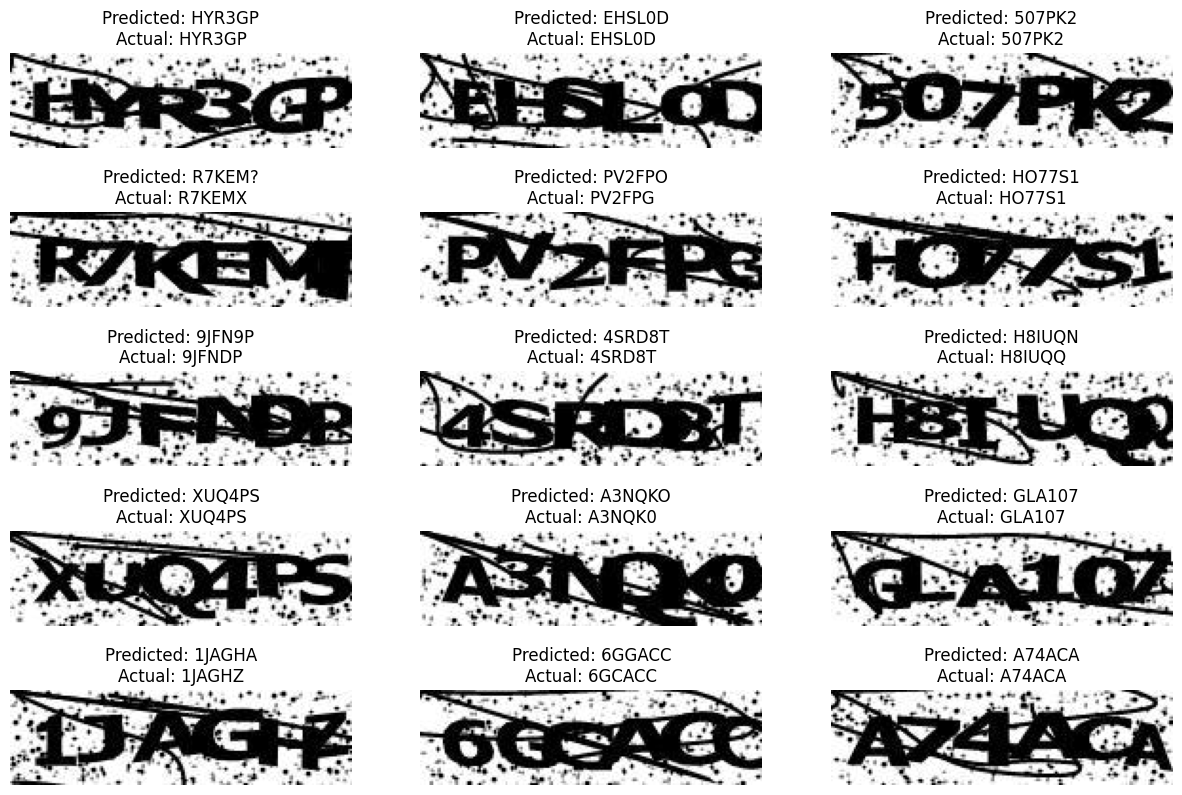

In [29]:
def show_predictions(model: Model, captchas: dict, rows_amount: int = 5):
    _, axs = plt.subplots(
        nrows=rows_amount,
        ncols=3,
        figsize=(15, 10),
        squeeze=False,
    )

    for row in range(rows_amount):
        for col in range(3):
            captcha = captchas[VALIDATION][row * 3 + col]
            prediction = model.predict(np.array([captcha["image"]]))

            predicted_label = convert_int_vectors_to_captchas_labels(np.array(prediction))

            axs[row, col].imshow(captcha["image"], cmap="gray")
            axs[row, col].set_title(f"Predicted: {predicted_label}\nActual: {captcha['label']}")
            axs[row, col].axis("off")

    plt.show()


show_predictions(model, captchas)

### Avaliação do Modelo
Para avaliar o modelo, será feita a predição do conjunto de teste e calculada a acurácia do modelo total e por quantidade de caracteres corretos.

In [32]:
def evaluate_model(model: Model, captchas: dict) -> pd.DataFrame:
    correct_predictions_histogram = {i+1: 0 for i in range(6)}
    for captcha in captchas[TEST]:
        prediction = model.predict(np.array([captcha["image"]]))
        predicted_label = convert_int_vectors_to_captchas_labels(np.array(prediction))
        
        total_correct = 0
        for i in range(6):
            if captcha["label"][i] == predicted_label[i]:
                total_correct += 1

        for i in range(1, total_correct + 1):
            correct_predictions_histogram[i] += 1

    return pd.DataFrame(correct_predictions_histogram, index=[0])


evaluation = evaluate_model(model, captchas)
evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

,1,2,3,4,5,6
0,0,0,5,46,359,589


## Referências
- [**Intuição por trás do algoritmo HOG**](https://www.youtube.com/watch?v=28xk5i1_7Zc)
- [**Intuição por trás do algoritmo SVM - Alternativa**](https://www.youtube.com/watch?v=RaaGoB8XnxM)